## Algoritmo LSTM

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import random
import joblib

In [2]:
# Establecer una semilla aleatoria
seed_value = 24
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(48)

In [3]:
nombre_csv = 4003
de = pd.read_csv(f'Datos_entrenamiento2/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba2/{nombre_csv}_p.csv')

# Procesamiento

In [4]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['nivel_estres'].value_counts()
conteo_nivel_estresdp = dp['nivel_estres'].value_counts()
# Mostramos el resultado
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

nivel_estres
Normal    2817
Leve       376
Alto       215
Name: count, dtype: int64
nivel_estres
Normal    2419
Leve       218
Alto        75
Name: count, dtype: int64


In [5]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'Normal': 0, 'Leve': 1, 'Alto': 2}
# Mapear las categorías a números utilizando el método map de pandas
de['nivel_estres'] = de['nivel_estres'].map(mapping)
dp['nivel_estres'] = dp['nivel_estres'].map(mapping)

# ALGORITMO DE LSTM

In [6]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de['nivel_estres']
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp['nivel_estres']

In [20]:
y_train

24      0
25      0
26      0
27      0
28      0
       ..
3403    1
3404    0
3405    0
3406    0
3407    0
Name: nivel_estres, Length: 3384, dtype: int64

In [7]:
# # Estandarizar las características
# scaler = joblib.load(f'scalers/{nombre_csv}_scaler.pkl')
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [8]:
#Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24

# X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
# y_train = y_train[timesteps:]
# X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
# y_test = y_test[timesteps:]

X_train_reshaped = np.array([X_train[i:i + timesteps] for i in range(len(X_train) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test[i:i + timesteps] for i in range(len(X_test) - timesteps)])
y_test = y_test[timesteps:]


In [ ]:
X_test_reshaped

In [9]:
# #Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [ ]:
y_train_categorical

In [11]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(72, activation='relu', input_shape=(timesteps, X_train.shape[1])),LSTM(576, activation='relu'))
model.add(Dense(144, activation='relu'))
model.add(Dense(36, activation='relu'))
# model.add(Dense(36, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','auc'])

# Entrenar el modelo
model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=48,
          validation_data=(X_test_reshaped, y_test_categorical))#, class_weight=class_weights_dict)


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8110 - auc: 0.8610 - loss: 0.7886 - val_accuracy: 0.8910 - val_auc: 0.9311 - val_loss: 0.4418
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8110 - auc: 0.8788 - loss: 0.6043 - val_accuracy: 0.8910 - val_auc: 0.9329 - val_loss: 0.4459
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8110 - auc: 0.8805 - loss: 0.6029 - val_accuracy: 0.8910 - val_auc: 0.9336 - val_loss: 0.4472
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8110 - auc: 0.8812 - loss: 0.6018 - val_accuracy: 0.8910 - val_auc: 0.9343 - val_loss: 0.4432
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8110 - auc: 0.8819 - loss: 0.6011 - val_accuracy: 0.8910 - val_auc: 0.9345 - val_loss: 0.4431
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8110 - auc: 0.8826 - loss: 0.6004 - val_accuracy: 0.8910 - val_auc: 0.9343 - val_loss: 0.4418
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1

In [12]:
# Guardar el modelo completo
#model.save(f'entrenamientos/{nombre_csv}_modelo_entrenado.h5')


In [13]:
# Predecir las etiquetas para el conjunto de prueba
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
# Contamos las ocurrencias de cada nivel de estrés
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
# Combina los valores únicos y sus conteos en un diccionario para facilitar la visualización
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))
# Mostramos el resultado
#print(conteo_nivel_estres)
print(ocurrencias)
print(ocurrenciaspre)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
{0: 2395, 1: 218, 2: 75}
{0: 2478, 1: 122, 2: 88}


In [14]:
# Comparar elemento por elemento
resultado = y_test==y_pred
conteo = np.sum(resultado)
print("Cantidad de coincidencias:", conteo)

Cantidad de coincidencias: 2232


In [15]:
comparacion = pd.DataFrame({'reales':y_test,'predichos':y_pred,'T/F':resultado})
comparacion

,reales,predichos,T/F
24,1,0,False
25,0,0,True
26,0,0,True
27,0,0,True
28,0,0,True
...,...,...,...
2707,0,0,True
2708,0,0,True
2709,0,0,True
2710,0,0,True


# EVALUACION DEL ALGORITMO

In [16]:
test_loss,test_acuracy, test_auc = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Acuracy: {test_acuracy}")
print(f"AUC en prueba: {test_auc}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7956 - auc: 0.8860 - loss: 1.2596
Acuracy: 0.8303571343421936
AUC en prueba: 0.9142639636993408


In [17]:
# EVALUACION DEL MODELO
from sklearn.preprocessing import label_binarize
y_pred2 = label_binarize(y_pred, classes=[0, 1, 2])
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcular el AUC
roc_auc = roc_auc_score(y_test_categorical, y_pred_proba, multi_class='ovr')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8303571428571429
Precision: 0.8073427546134962
Recall: 0.8303571428571429
F1 Score: 0.8179493667253972
ROC AUC: 0.5287606895290432


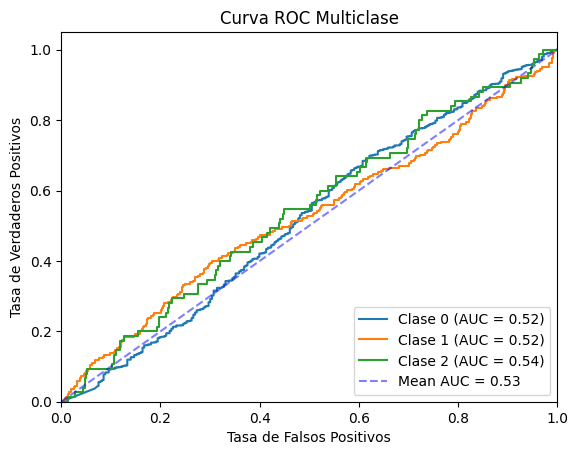

In [18]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()